In [1]:
%pylab inline
from libanalysis import PhantomAnalysis as pa
from scipy.signal import savgol_filter

from scipy import signal
from scipy.signal import find_peaks

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_acc_particle(dump, R):
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    return r <= R

def inter_ep(dump):
    m = dump.massofgas
    
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    ep = np.zeros(x.shape)

    for xx, yy, zz, i in zip(x, y, z, range(len(x))):
        dx = x - xx
        dy = y - yy
        dz = z - zz
        dr = np.sqrt(dx**2 + dy**2 + dz**2)
        p = (1/dr[dr!=0]).sum()
        ep[i] = -p*m
        
    return ep

def get_E(dump, Mb):
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    ep = -Mb/r #+ inter_ep(dump)
    
    vx = dump.vxyz[0]
    vy = dump.vxyz[1]
    vz = dump.vxyz[2]
    
    ek = 0.5*(vx**2 + vy**2 + vz**2)
    
    return ep+ek

def get_ecc(dump, Mb):
    
    u = Mb
    
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    vx = dump.vxyz[0]
    vy = dump.vxyz[1]
    vz = dump.vxyz[2]
    
    v2 = np.sqrt(vx**2 + vy**2 + vz**2)
    
    dot = x*vx + y*vy + z*vz
    
    rcof = v2/u - 1/r
    
    vcof = dot/u
    
    ex = rcof * x - vcof * vx
    
    ey = rcof * y - vcof * vy
    
    ez = rcof * z - vcof * vz
    
    e = np.sqrt(ex**2 + ey**2 + ez**2)
    
    return e

def get_bound(dump, Mb):
    return get_E(dump, Mb) < 0
    
def get_disk_particle(dump, Mb):
    E = get_E(dump, 10)
    a = -10/2/E
    
    xbins = 'auto'
    
    amin = 0.5
    amax = 100
    
    num, bins = np.histogram(np.log10(a[(amin<a)&(a<amax)]),bins=xbins,density=True)

    cbin = 0.5*(bins[0:-1] + bins[1::])
    
    zero = np.argmin(num)
    
    valley_idx = signal.argrelextrema(num, np.less, order=2)
    valley_idx = valley_idx[0]

    peaks, _ = find_peaks(num, prominence=0.25)
    
    disjoint = 0
    if( (len(peaks)>1)):
        peak1 = peaks[0]
        peak2 = peaks[1]
    
        if (peak1 < zero) & (zero < peak2):
            disjoint = zero
        elif len(valley_idx) > 0:
            for v in valley_idx:
                if (peak1 < v)&(v < peak2)&(v>disjoint):
                    disjoint = v
        
    
    if disjoint == 0:
        critical_a = 0
    else:
        critical_a = 10**cbin[disjoint]
    
    return (a < critical_a) & (a>0)

def get_fall_particle(dump, Mb, R):
    return get_disk_particle(dump, Mb) | get_acc_particle(dump, R)
    
def draw(dump, idx):
    plt.figure()
    plt.scatter(dump.xyzh[0][idx], dump.xyzh[1][idx],s=0.001)
    plt.scatter(dump.xyzh[0][~idx], dump.xyzh[1][~idx],s=0.001)

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to loa

/home/yihan/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to loa

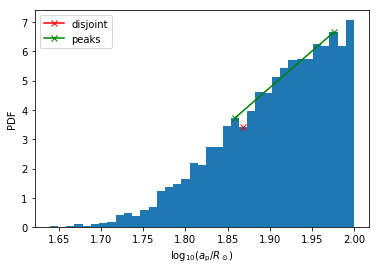

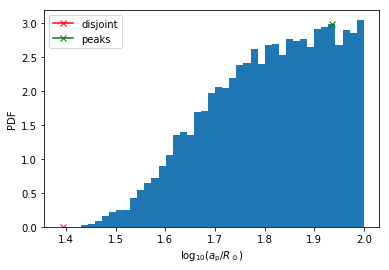

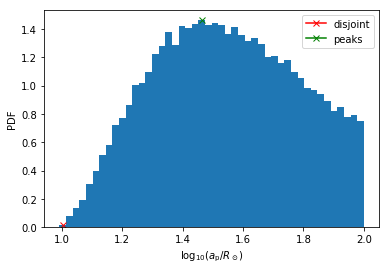

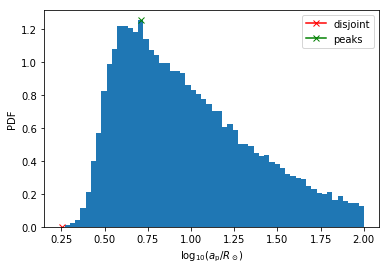

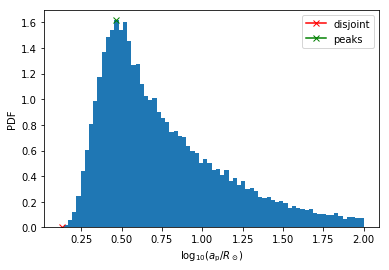

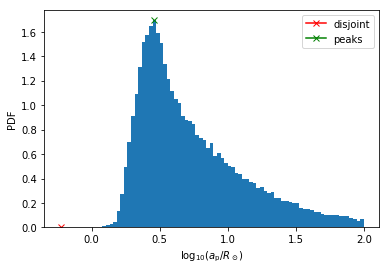

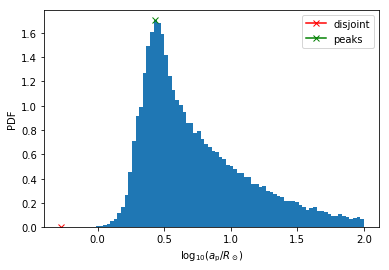

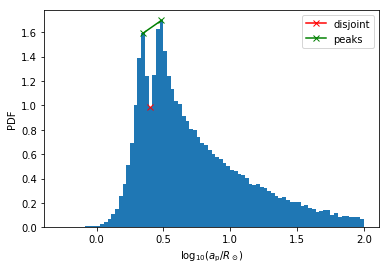

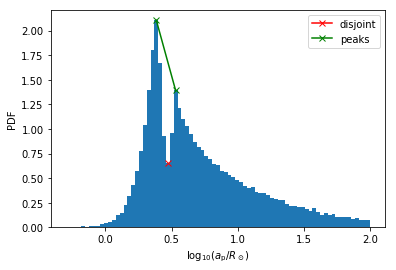

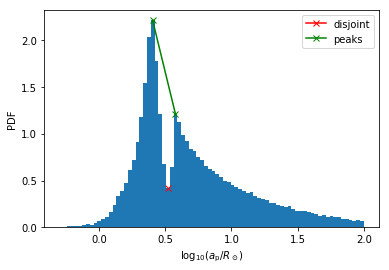

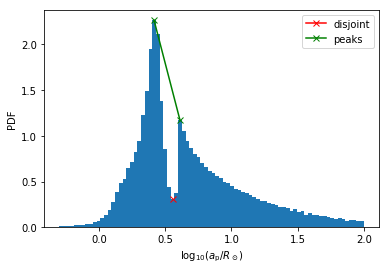

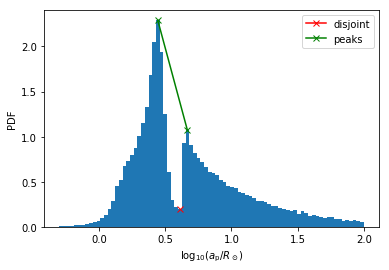

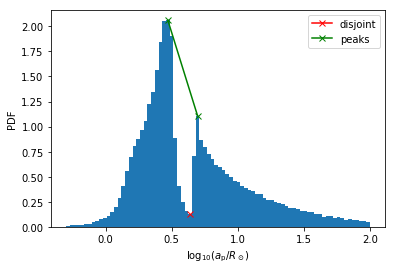

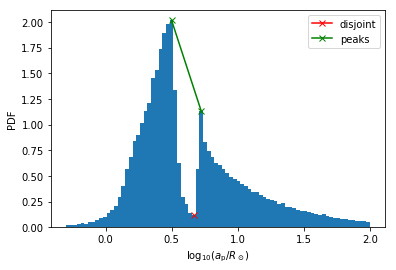

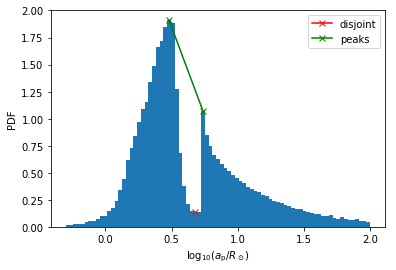

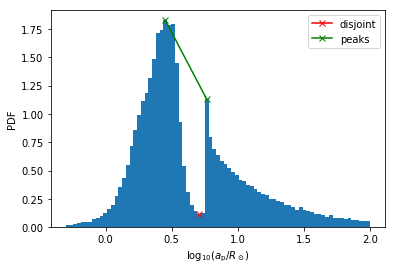

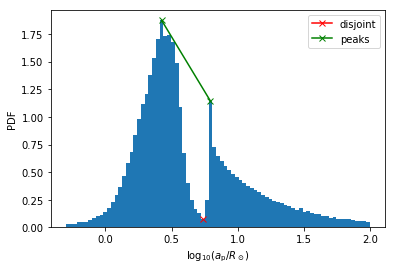

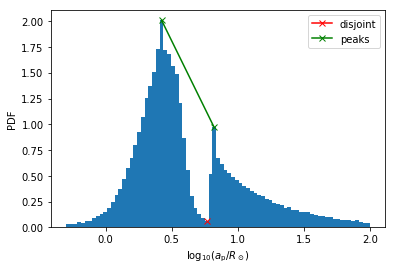

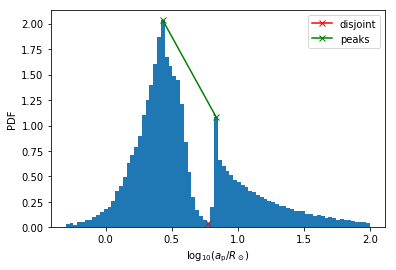

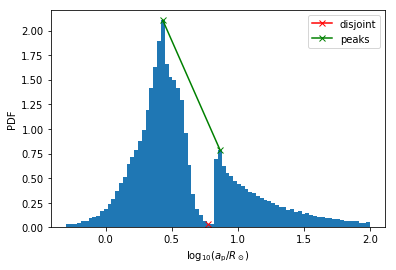

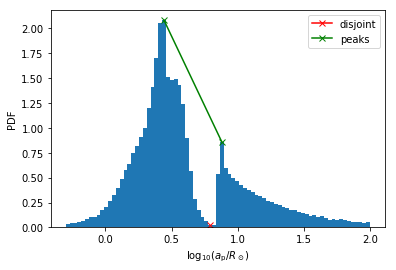

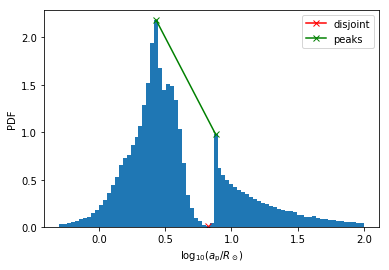

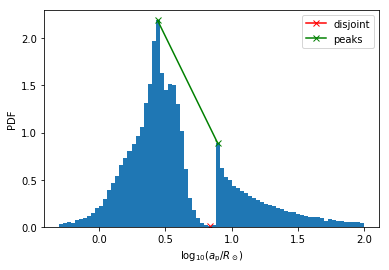

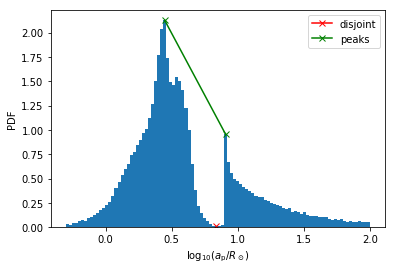

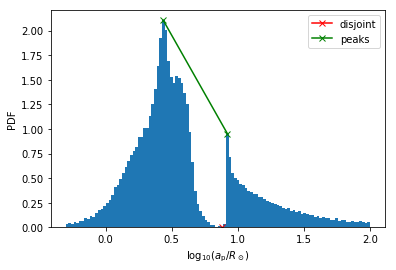

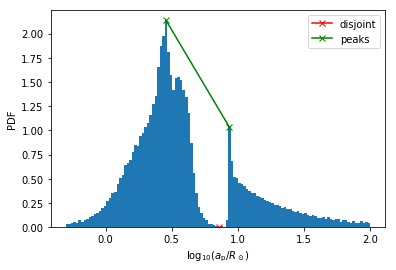

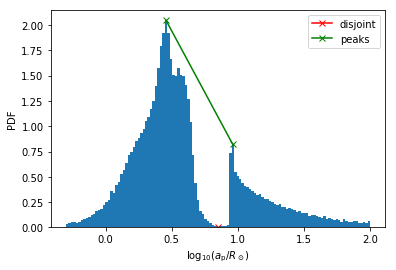

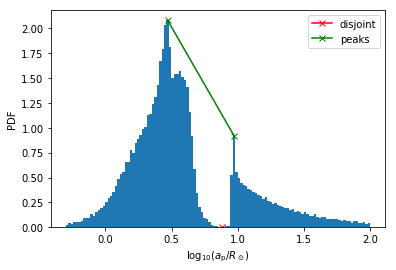

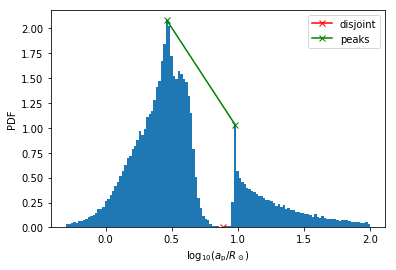

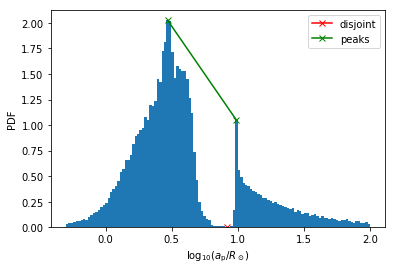

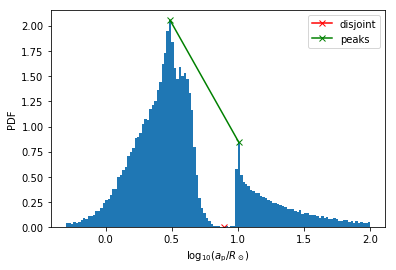

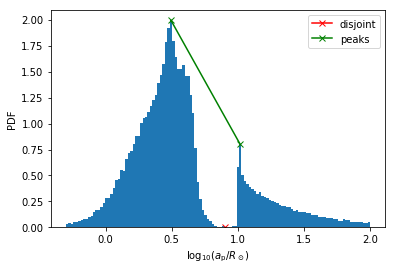

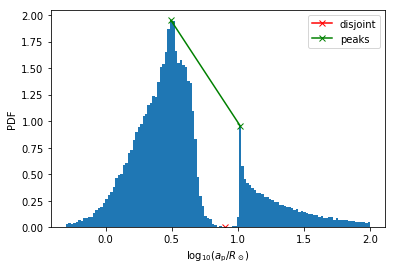

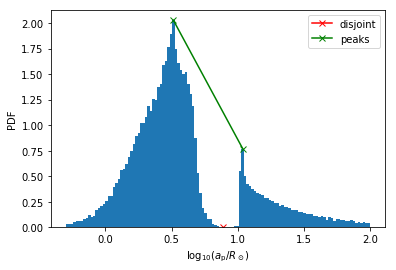

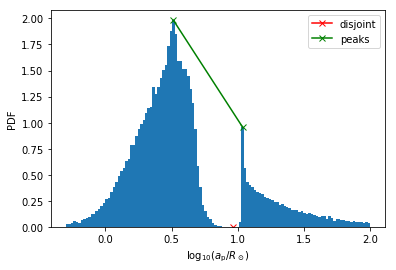

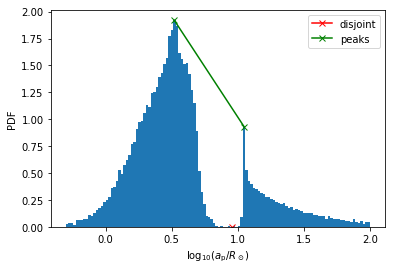

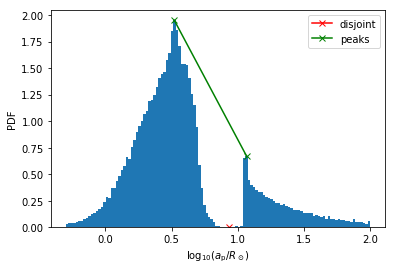

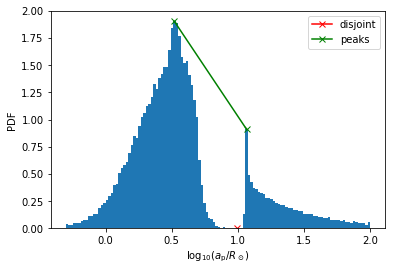

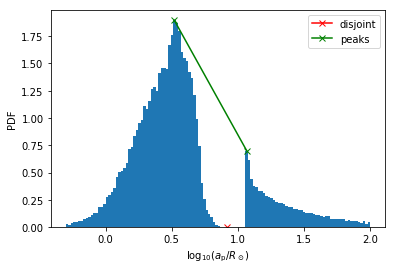

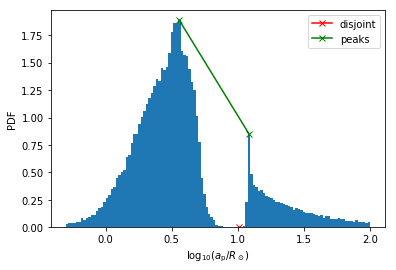

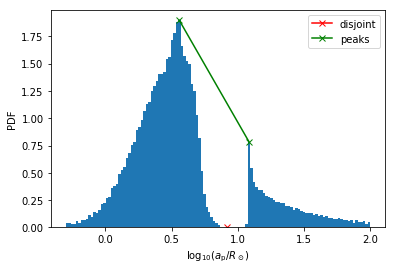

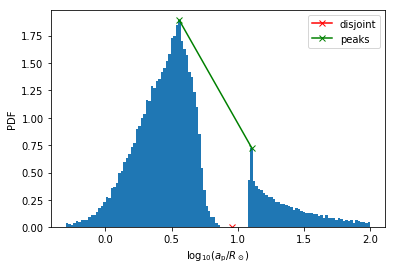

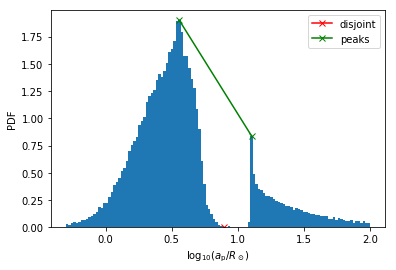

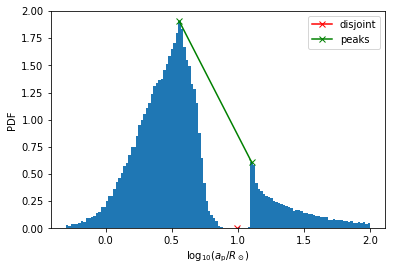

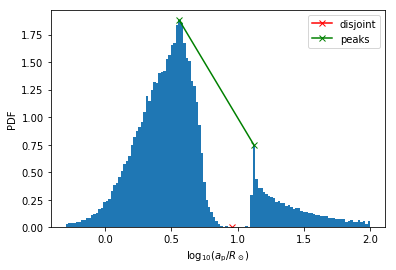

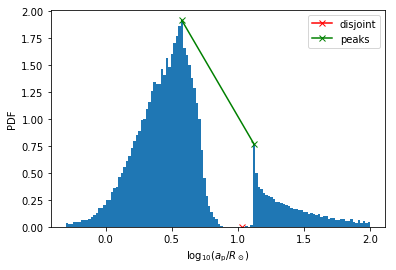

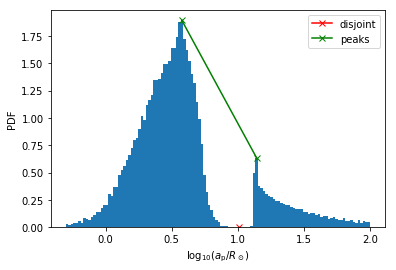

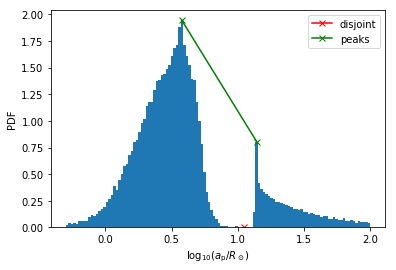

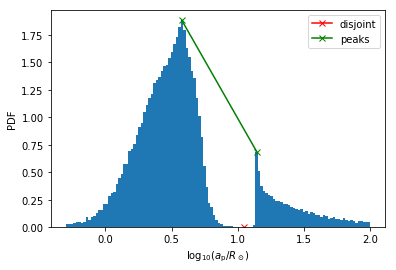

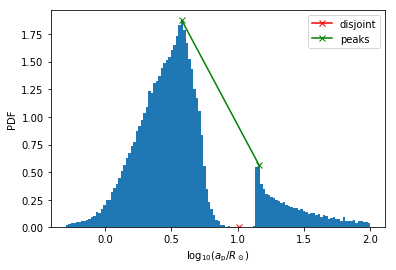

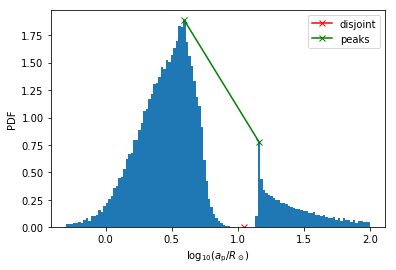

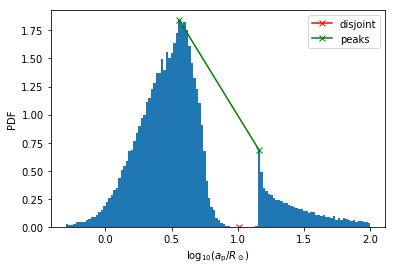

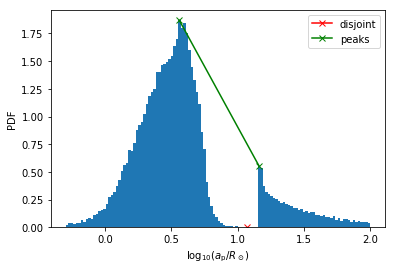

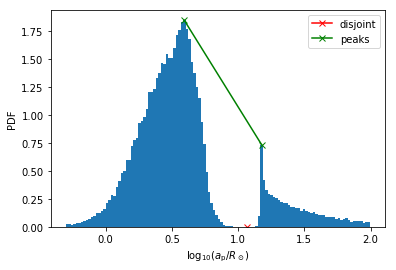

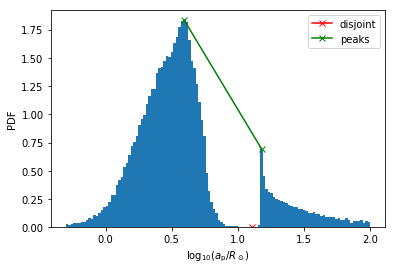

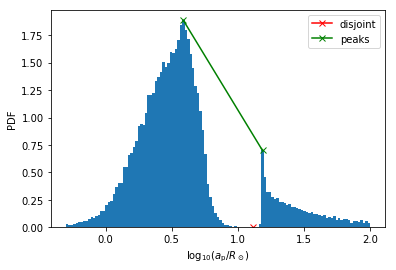

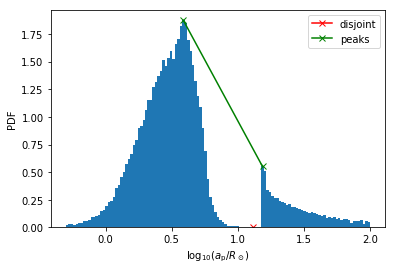

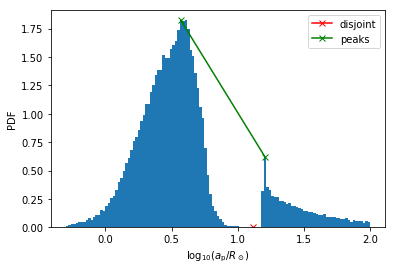

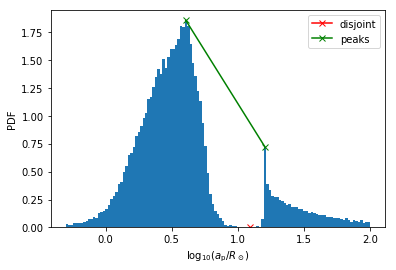

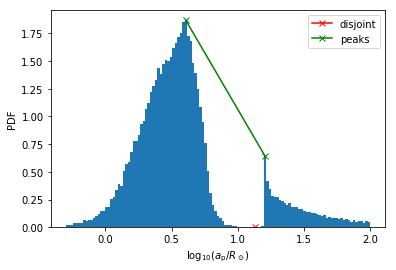

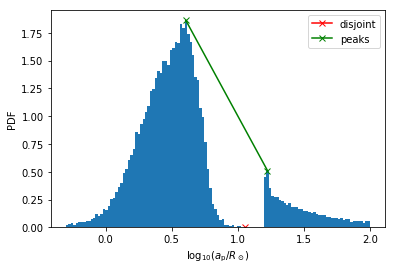

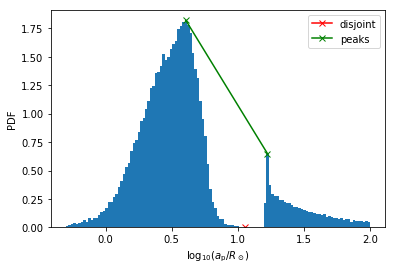

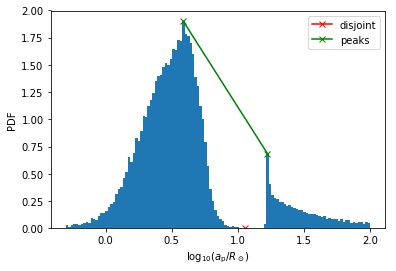

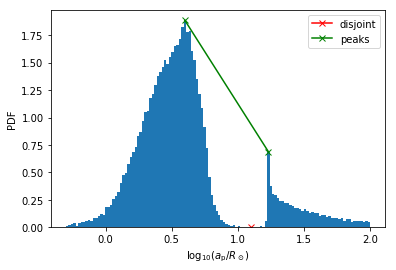

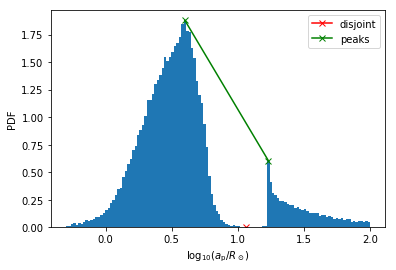

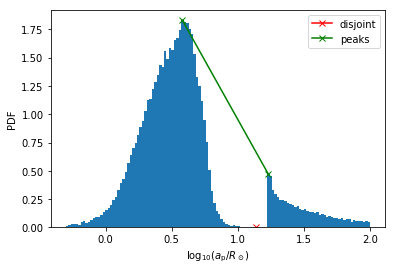

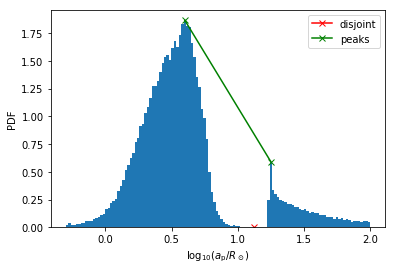

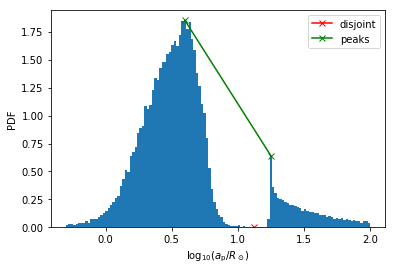

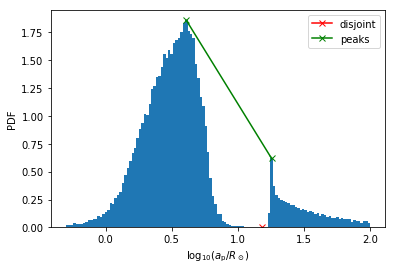

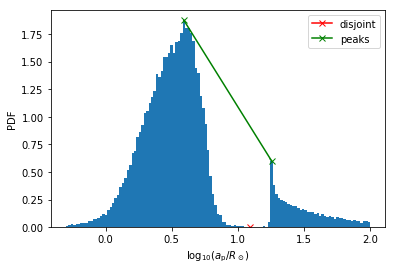

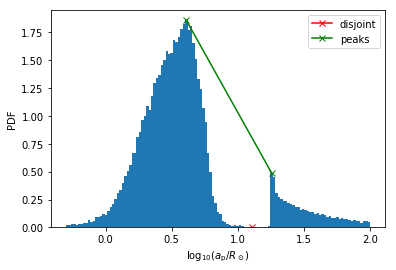

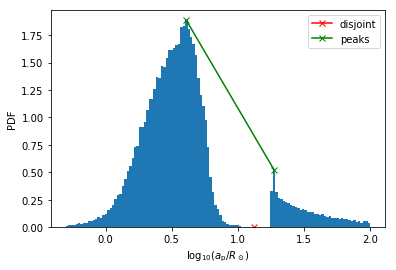

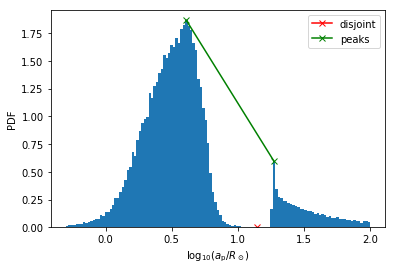

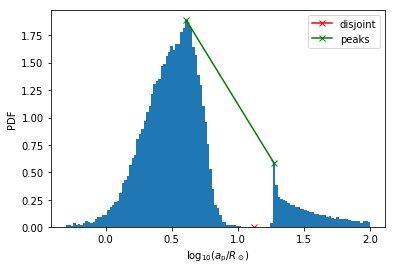

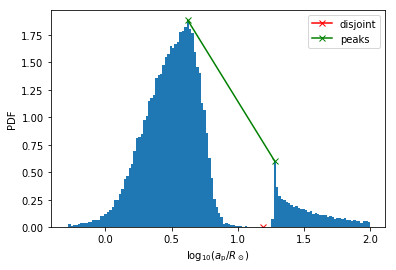

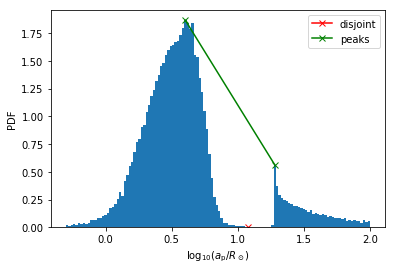

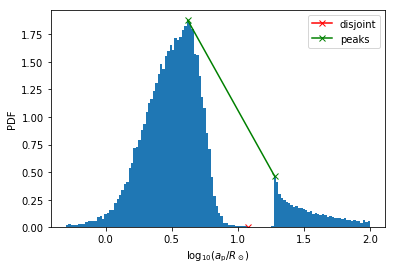

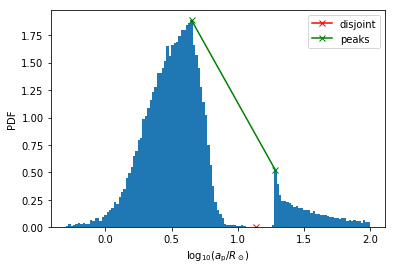

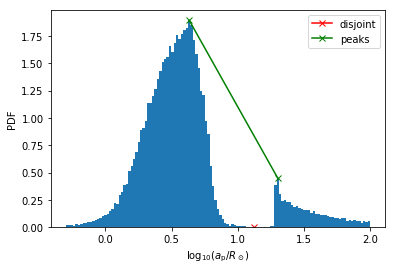

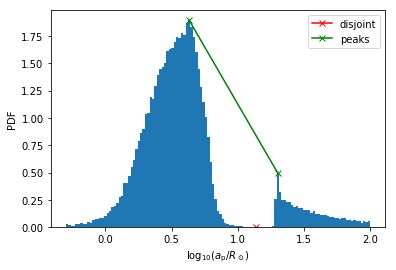

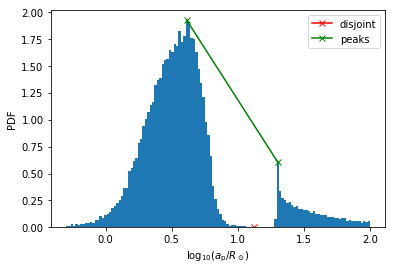

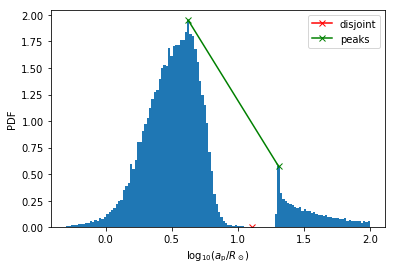

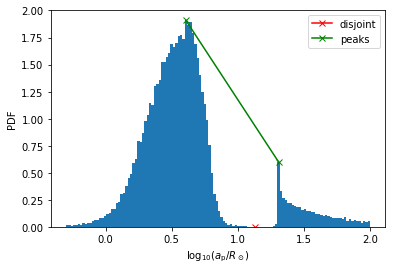

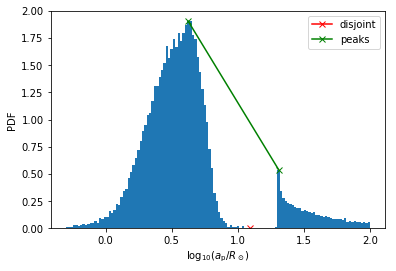

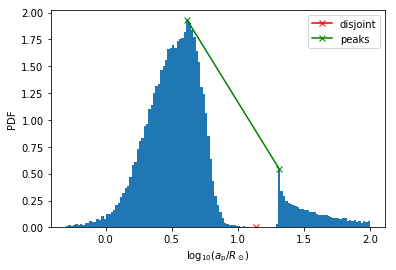

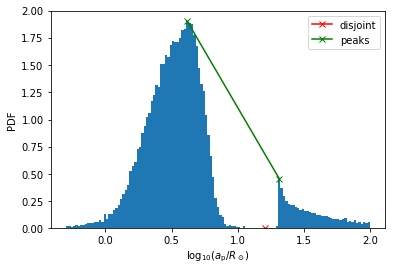

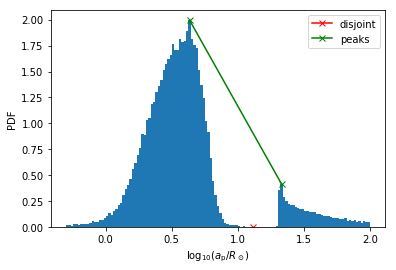

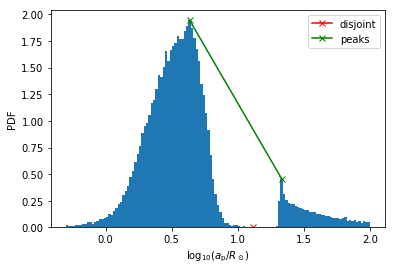

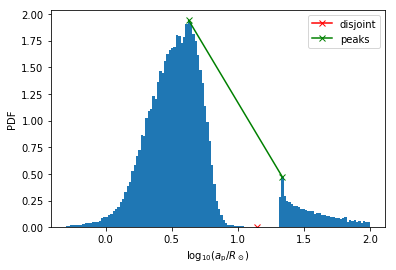

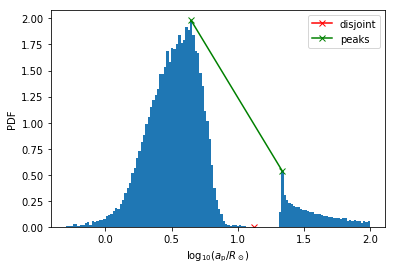

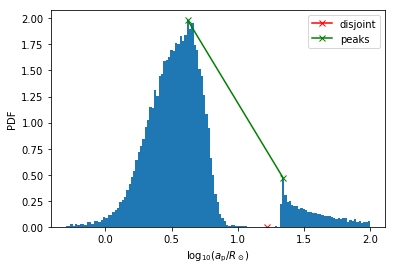

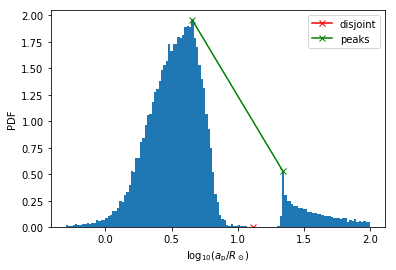

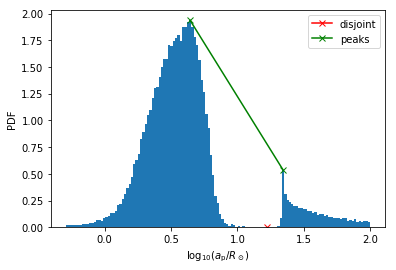

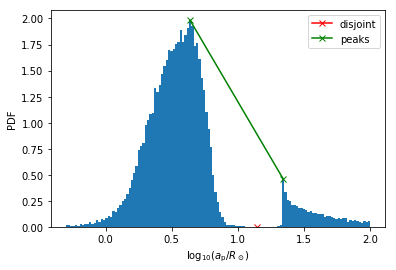

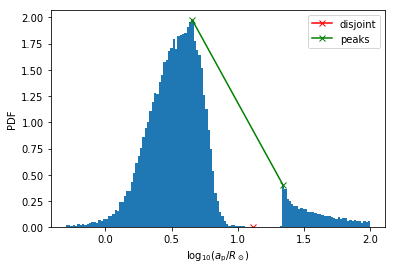

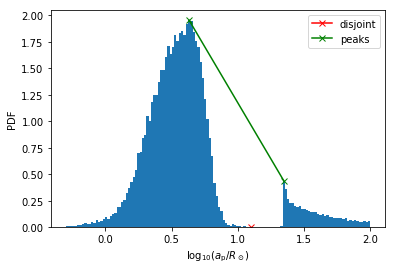

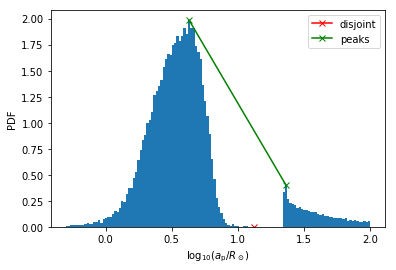

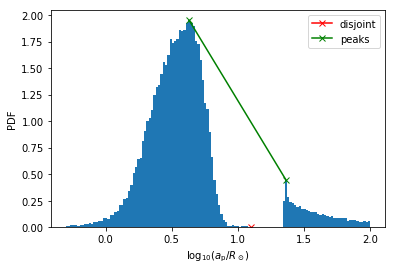

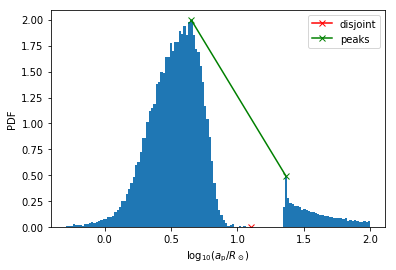

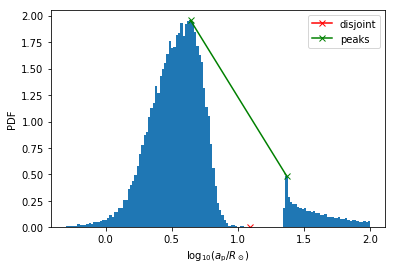

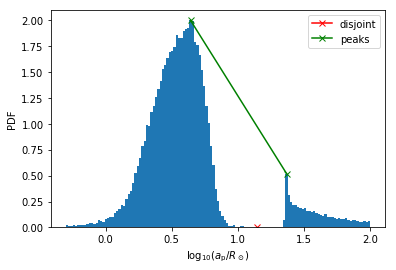

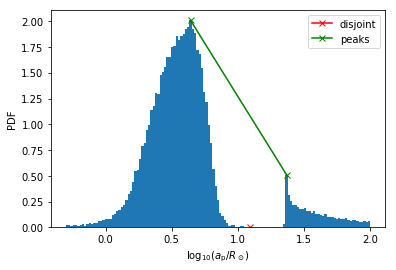

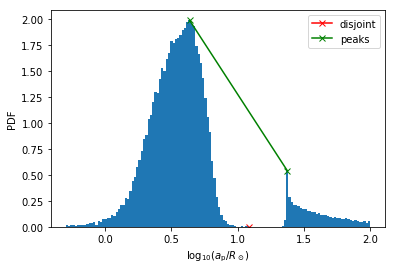

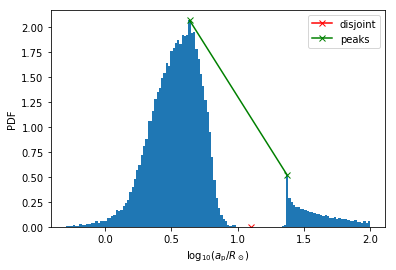

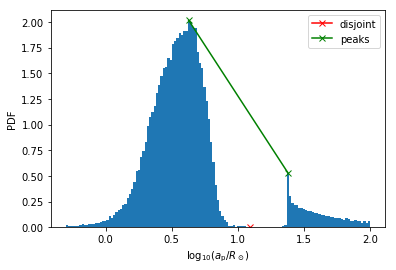

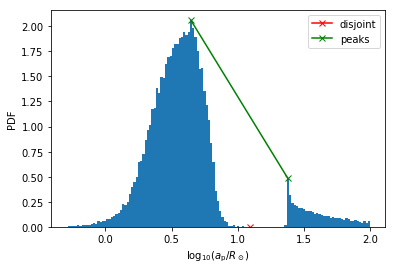

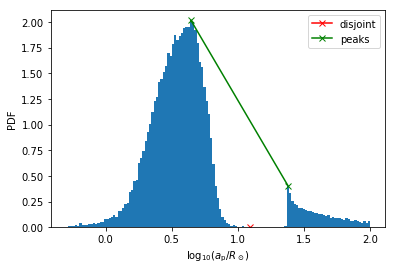

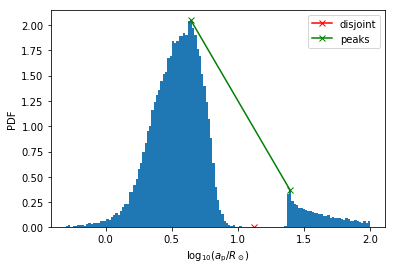

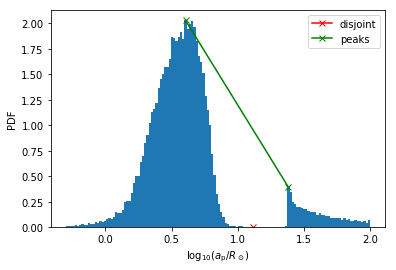

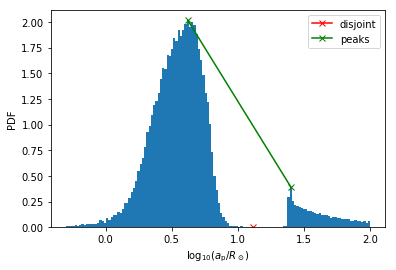

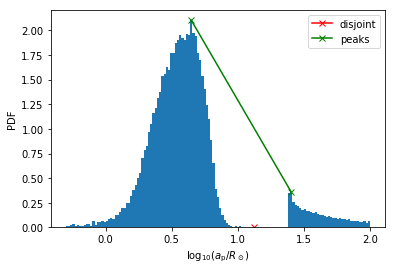

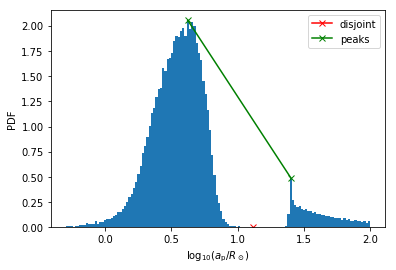

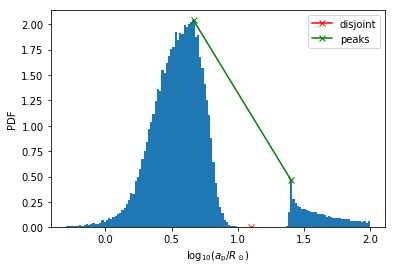

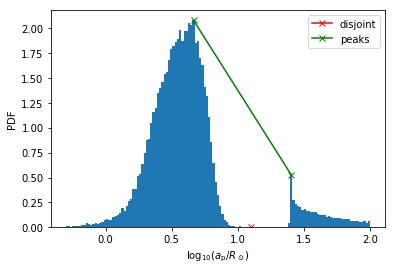

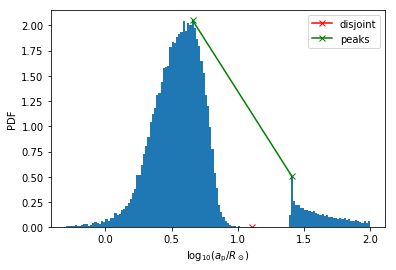

In [3]:
def draw_a(dump, Mb, figname):
    a = -Mb/2/get_E(dump, Mb)
    xbins = 'auto'
    
    amin = 0.5
    amax = 100
    
    num, bins = np.histogram(np.log10(a[(amin<a)&(a<amax)]),bins=xbins,density=True)
    
    plt.figure()
    plt.hist(np.log10(a[(amin<a)&(a<amax)]),bins=xbins,density=True)

    cbin = 0.5*(bins[0:-1] + bins[1::])
    
    zero = np.argmin(num)
    
    valley_idx = signal.argrelextrema(num, np.less, order=2)
    valley_idx = valley_idx[0]

    peaks, _ = find_peaks(num, prominence=0.25)
    
    disjoint = 0
    if( (len(peaks)>1)):
        peak1 = peaks[0]
        peak2 = peaks[1]
    
        if (peak1 < zero) & (zero < peak2):
            disjoint = zero
        elif len(valley_idx) > 0:
            for v in valley_idx:
                if (peak1 < v)&(v < peak2)&(v>disjoint):
                    disjoint = v
                    
    plt.plot(cbin[disjoint], num[disjoint],color='r',marker='x',label='disjoint')
    plt.plot(cbin[peaks], num[peaks],color='g',marker='x',label='peaks')
    plt.legend()
    plt.xlabel('$\log_{10}(a_{\\rm p}/R_\odot)$')
    plt.ylabel('PDF')
    plt.savefig(figname,dpi=192)
    
    
prefix = '../low_N/rp1/'
idx = np.linspace(0,1140,115)

for i in idx:
    fname = 'tde_%05d'% i
    dump = pa(prefix+fname)
    draw_a(dump, 10,'figs/dist_a_%05d.png' % (i/10))

In [ ]:
colors = cm.viridis(np.linspace(0,1,3))
def draw_classify(dump, Mb, figname):
    disk = get_disk_particle(dump, 10)
    acc = get_acc_particle(dump, 4.2e-3)
    rem = (~acc) & (~disk)
  
    plt.figure()
    plt.scatter(dump.xyzh[0][rem], dump.xyzh[1][rem],s=0.01,color='orange')
    
    plt.scatter(dump.xyzh[0][disk], dump.xyzh[1][disk],s=0.01,color='red')
    
    plt.scatter(dump.xyzh[0][acc], dump.xyzh[1][acc],s=0.001,color='k')
    
    plt.legend()
    plt.xlabel('x [$R_\odot$]')
    plt.ylabel('y [$R_\odot$]')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.savefig(figname,dpi=192)
    
    
prefix = '../low_N/rp1/'
idx = np.linspace(0,1140,115)

for i in idx:
    fname = 'tde_%05d'% i
    dump = pa(prefix+fname)
    draw_classify(dump, 10,'figs/classify_%05d.png' % (i/10))

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.


(array([4.21823863e-03, 0.00000000e+00, 6.32735795e-03, 2.10911932e-03,
        2.10911932e-02, 5.90553408e-02, 1.18110682e-01, 3.98623551e-01,
        2.55625261e+00, 8.17916471e+00, 9.01226684e+00, 6.68168999e+00,
        4.61053482e+00, 3.71205000e+00, 3.15102426e+00, 2.70178184e+00,
        2.61952619e+00, 2.37486835e+00, 2.29261270e+00, 2.25253943e+00,
        2.11966491e+00, 2.05850045e+00, 2.03530014e+00, 1.92140770e+00,
        1.84969764e+00, 1.79696966e+00, 1.81806085e+00, 1.68307721e+00,
        1.75056903e+00, 1.64722219e+00, 1.60925804e+00, 1.55020270e+00,
        1.61558540e+00, 1.47849264e+00, 1.58605773e+00, 1.51223855e+00,
        1.52278415e+00, 1.54176622e+00, 1.38780051e+00, 1.46161969e+00,
        1.45740145e+00, 1.43631025e+00, 1.41943730e+00, 1.45107409e+00]),
 array([0.51361839, 0.52467247, 0.53572655, 0.54678062, 0.5578347 ,
        0.56888878, 0.57994286, 0.59099694, 0.60205102, 0.6131051 ,
        0.62415918, 0.63521325, 0.64626733, 0.65732141, 0.66837549,
  

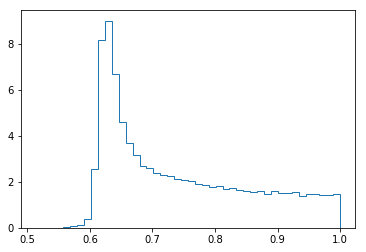

In [420]:
dump = pa('../low_N/rp09/tde_00080')
ecc=get_ecc(dump, 10)
plt.figure()
plt.hist(ecc[ecc<1],bins='auto',histtype='step',density=True)

In [4]:
def get_masses(prefix, idx):
    times =[]
    disk_m=[]
    acc_m =[]
    for i in idx:
        fname = 'tde_%05d'% i
        dump = pa(prefix+fname)
        times.append(dump.time * dump.units['utime'])
        disk_m.append(dump.massofgas * (get_disk_particle(dump, 10)).sum())
        acc_m.append(dump.massofgas * (get_acc_particle(dump, 4.2e-3)).sum())
   

    times = np.array(times)
    disk_m = np.array(disk_m)
    acc_m = np.array(acc_m)
    return times, disk_m, acc_m

times_1, disk_m_1, acc_m_1 = get_masses('../low_N/rp1/', np.linspace(0,1150,116))

times_09, disk_m_09, acc_m_09 = get_masses('../low_N/rp09/', np.linspace(0,1220,123))

times_06, disk_m_06, acc_m_06 = get_masses('../low_N/rp06/', np.linspace(0,1250,126))

times =[times_1, times_09, times_06]
disk_m = [disk_m_1, disk_m_09, disk_m_06]
acc_m = [acc_m_1, acc_m_09, acc_m_06]

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to loa

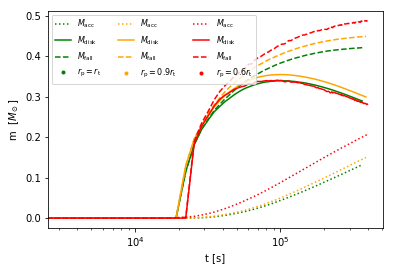

In [5]:
colors = ['g','orange','r']
labels = ['$r_{\\rm p}=r_{\\rm t}$', '$r_{\\rm p}=0.9r_{\\rm t}$', '$r_{\\rm p}=0.6r_{\\rm t}$' ]

plt.figure()
for c, t, d, a, l in zip(colors, times, disk_m, acc_m, labels):
    plt.plot(t, a,ls=':', label='$M_{\\rm acc}$', color=c)
    plt.plot(t, d,ls='-', label='$M_{\\rm disk}$', color=c)
    plt.plot(t, a+d,ls='--',label='$M_{\\rm fall}$', color=c)
    plt.plot([],[],'.',label=l,color=c)
plt.xscale('log')
plt.legend(ncol=3,fontsize=8)
plt.xlabel('t [s]')
plt.ylabel('m  [$M_\odot$]')
plt.savefig('accumulated_m.png',dpi=192)

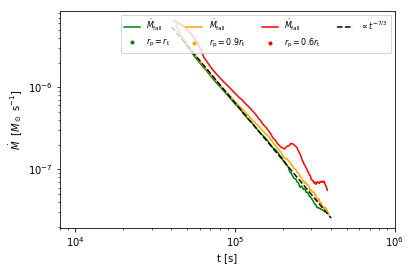

In [10]:
def diff(x, y, step):
    dx = x[1] - x[0]
    return 0.5*(x[step::] + x[0:-step]), savgol_filter((y[step::] - y[0:-step])/(dx*step), 13, 1)
    


ct = 4e4

steps =[1,1,12]
plt.figure()
for c, t, d, a, l, step  in zip(colors, times, disk_m, acc_m, labels, steps):
    #dt, da = diff(t, a, step)
    #plt.plot(dt, da, ls=':', label='$\dot{M}_{\\rm acc}$', color=c)
    #dt, dd = diff(t, d, step)
    #plt.plot(dt[dt>ct], dd[dt>ct], ls='--', label='$\dot{M}_{\\rm disk}$', color=c)
    dt, df = diff(t, a+d, step)
    plt.plot(dt[dt>ct], df[dt>ct], ls='-',label='$\dot{M}_{\\rm fall}$', color=c)
    plt.plot([],[],'.',label=l,color=c)
    
time = np.linspace(ct, 4e5)
power1 = 2e2*time**(-5.0/3)
power2 = 0.3e6*time**(-7.0/3)
#plt.plot(time, power1, color='k',ls='-', label='Phinney 1989 $\propto t^{-5/3}$')
plt.plot(time, power2, color='k',ls='--', label='$\propto t^{-7/3}$')

plt.xscale('log')
plt.yscale('log')
plt.legend(ncol=4,fontsize=8)
plt.xlabel('t [s]')
plt.xlim(8e3, 1e6)
plt.ylabel('$\dot{M}$  [$M_\odot$ s$^{-1}$]')
plt.savefig('m_dot.png',dpi=192)